# Learnable Timescale Initialization Sweep

**Research Question**: Does the final learned timescale distribution depend on the initial timescale value, or does training converge to a similar distribution regardless of initialization?

If different initializations converge to similar final distributions, this suggests there's an "optimal" timescale distribution that the network learns to match the behavioral timescale of the task.


## Setup


In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

import subprocess
import os
import sys

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "timescales"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
sys.path.append(os.getcwd())


Working directory:  /home/facosta/timescales/timescales


In [2]:
from pathlib import Path
import json
import yaml
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from timescales.rnns.multitimescale_rnn import (
    MultiTimescaleRNN,
    MultiTimescaleRNNLightning,
)

In [3]:
# Update this to your sweep directory
sweep_dir = Path(
    "/home/facosta/timescales/timescales/logs/experiments/learnable_timescale_init_sweep_20260122_225001"
)
print(f"Sweep directory: {sweep_dir}")
print(f"Exists: {sweep_dir.exists()}")

# List available experiments
if sweep_dir.exists():
    experiments = sorted([d.name for d in sweep_dir.iterdir() if d.is_dir()])
    print(f"Found {len(experiments)} experiments:")
    for exp in experiments:
        print(f"  - {exp}")

Sweep directory: /home/facosta/timescales/timescales/logs/experiments/learnable_timescale_init_sweep_20260122_225001
Exists: True
Found 17 experiments:
  - configs
  - init_tau_0.05_ReLU
  - init_tau_0.05_Tanh
  - init_tau_0.1_ReLU
  - init_tau_0.1_Tanh
  - init_tau_0.2_ReLU
  - init_tau_0.2_Tanh
  - init_tau_0.3_ReLU
  - init_tau_0.3_Tanh
  - init_tau_0.5_ReLU
  - init_tau_0.5_Tanh
  - init_tau_0.7_ReLU
  - init_tau_0.7_Tanh
  - init_tau_1.5_ReLU
  - init_tau_1.5_Tanh
  - init_tau_1_ReLU
  - init_tau_1_Tanh


## Load Final Timescales from Each Experiment


In [4]:
# Grid of initial timescale values (updated for new sweep)
init_timescales = [0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.5]
activation_types = ["Tanh", "ReLU"]


def format_value(v):
    """Format value for experiment naming - removes .0 from whole numbers."""
    if float(v) == int(v):
        return str(int(v))
    return str(v)


def load_final_timescales(sweep_dir, init_tau, activation, seed=0):
    """Load the final learned timescales from a trained model."""
    # New naming format: init_tau_{value}_{activation}
    exp_name = f"init_tau_{format_value(init_tau)}_{activation}"
    exp_path = sweep_dir / exp_name / f"seed_{seed}"

    # Load config
    config_path = exp_path / f"config_seed{seed}.yaml"
    with open(config_path) as f:
        config = yaml.safe_load(f)

    # Find best checkpoint
    checkpoint_dir = exp_path / "checkpoints"
    best_checkpoints = list(checkpoint_dir.glob("best-model-*.ckpt"))
    checkpoint_path = (
        best_checkpoints[0] if best_checkpoints else checkpoint_dir / "last.ckpt"
    )

    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location="cpu")

    # Create and load model
    model = MultiTimescaleRNN(
        input_size=config["input_size"],
        hidden_size=config["hidden_size"],
        output_size=config["num_place_cells"],
        dt=config["dt"],
        timescales_config=None,
        activation=getattr(nn, config["activation"]),
        learn_timescales=True,
        init_timescale=init_tau,
    )

    lightning_module = MultiTimescaleRNNLightning(
        model=model,
        learning_rate=config["learning_rate"],
        weight_decay=config["weight_decay"],
        step_size=config["step_size"],
        gamma=config["gamma"],
    )
    lightning_module.load_state_dict(checkpoint["state_dict"])

    # Extract timescales
    timescales = model.rnn_step.current_timescales.detach().cpu().numpy()

    # Load training metrics
    with open(exp_path / "training_losses.json") as f:
        losses = json.load(f)

    return {
        "timescales": timescales,
        "init_tau": init_tau,
        "activation": activation,
        "final_val_loss": losses["val_losses_epoch"][-1],
        "config": config,
    }


# Load all experiments - organized by activation type
results = {act: {} for act in activation_types}

for activation in activation_types:
    print(f"\n=== {activation} Networks ===")
    for init_tau in init_timescales:
        try:
            data = load_final_timescales(sweep_dir, init_tau, activation, seed=0)
            results[activation][init_tau] = data
            print(
                f"  Loaded init_tau={init_tau}: mean={data['timescales'].mean():.3f}, "
                f"std={data['timescales'].std():.3f}"
            )
        except Exception as e:
            print(f"  Failed to load init_tau={init_tau}: {e}")

total_loaded = sum(len(r) for r in results.values())
print(
    f"\nLoaded {total_loaded} experiments ({len(results['Tanh'])} Tanh, {len(results['ReLU'])} ReLU)"
)


=== Tanh Networks ===
Timescales are LEARNABLE (per-neuron, uniform init at τ=0.05s)
Gradient preconditioning DISABLED
  Loaded init_tau=0.05: mean=0.034, std=0.007
Timescales are LEARNABLE (per-neuron, uniform init at τ=0.1s)
Gradient preconditioning DISABLED
  Loaded init_tau=0.1: mean=0.066, std=0.015
Timescales are LEARNABLE (per-neuron, uniform init at τ=0.2s)
Gradient preconditioning DISABLED
  Loaded init_tau=0.2: mean=0.129, std=0.035
Timescales are LEARNABLE (per-neuron, uniform init at τ=0.3s)
Gradient preconditioning DISABLED
  Loaded init_tau=0.3: mean=0.196, std=0.054
Timescales are LEARNABLE (per-neuron, uniform init at τ=0.5s)
Gradient preconditioning DISABLED
  Loaded init_tau=0.5: mean=0.333, std=0.102
Timescales are LEARNABLE (per-neuron, uniform init at τ=0.7s)
Gradient preconditioning DISABLED
  Loaded init_tau=0.7: mean=0.449, std=0.146
Timescales are LEARNABLE (per-neuron, uniform init at τ=1.0s)
Gradient preconditioning DISABLED
  Loaded init_tau=1.0: mean=0.586

In [5]:
# Get behavioral timescale from first experiment's config
first_activation = list(results.keys())[0]
first_result = list(results[first_activation].values())[0]
config = first_result["config"]

if (
    "behavioral_timescale_mean" in config
    and config["behavioral_timescale_mean"] is not None
):
    behavioral_timescale_mean = config["behavioral_timescale_mean"]
    behavioral_timescale_std = config.get("behavioral_timescale_std", 0.2)
else:
    behavioral_timescale_mean = config["place_cell_rf"] / config["linear_speed_mean"]
    behavioral_timescale_std = 0.2

print(
    f"Behavioral timescale: mean={behavioral_timescale_mean}s, std={behavioral_timescale_std}s"
)

# Sample behavioral timescales
np.random.seed(42)
behavioral_timescales = np.abs(
    np.random.normal(behavioral_timescale_mean, behavioral_timescale_std, 10000)
)
behavioral_timescales = np.clip(behavioral_timescales, 0.01, None)

Behavioral timescale: mean=1.0s, std=0.2s


## Compare Final Timescale Distributions


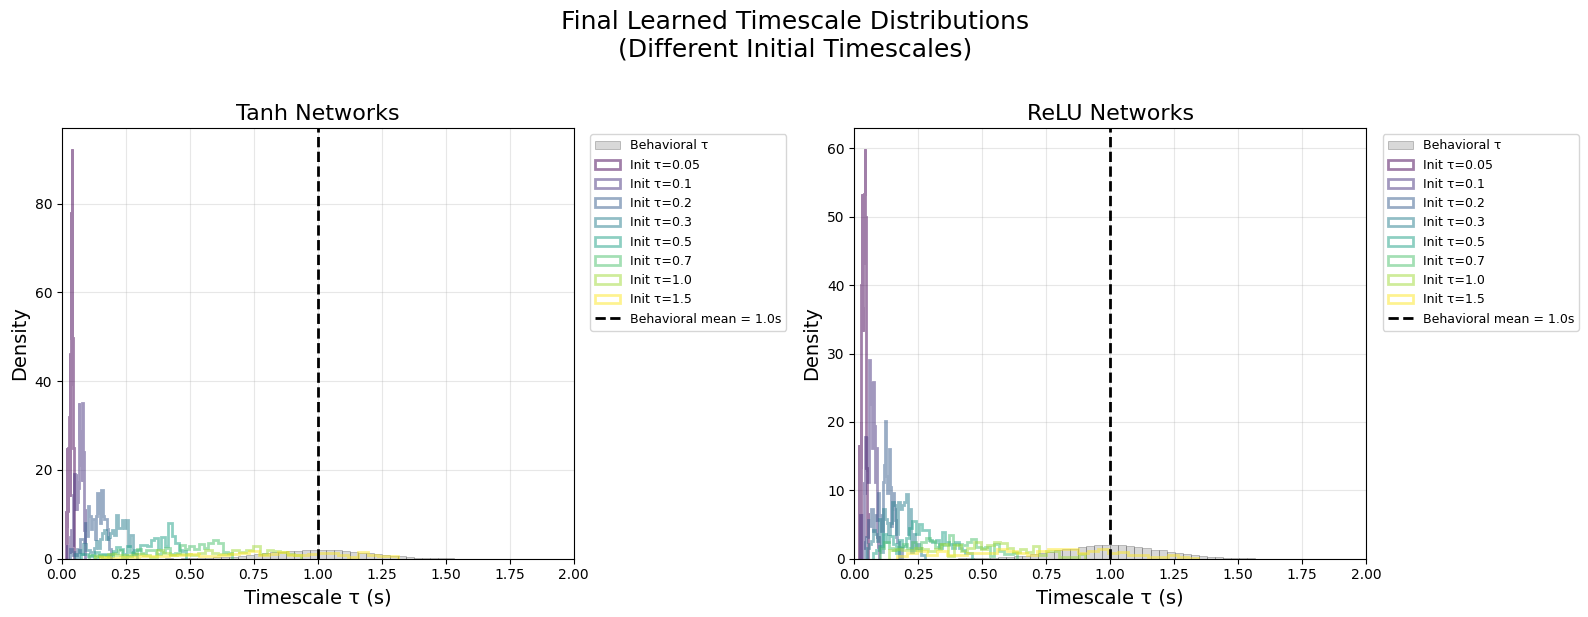

In [6]:
# Create figure with overlapping histograms - one per activation type
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax_idx, activation in enumerate(activation_types):
    ax = axes[ax_idx]
    act_results = results[activation]

    # Color map for different initializations
    colors = plt.cm.viridis(np.linspace(0, 1, len(act_results)))

    # Plot behavioral distribution first (background)
    ax.hist(
        behavioral_timescales,
        bins=50,
        alpha=0.3,
        color="gray",
        density=True,
        label="Behavioral τ",
        edgecolor="black",
        linewidth=0.5,
    )

    # Plot each final timescale distribution
    for i, (init_tau, data) in enumerate(sorted(act_results.items())):
        ax.hist(
            data["timescales"],
            bins=30,
            alpha=0.5,
            color=colors[i],
            density=True,
            label=f"Init τ={init_tau}",
            histtype="step",
            linewidth=2,
        )

    ax.axvline(
        behavioral_timescale_mean,
        color="black",
        linestyle="--",
        linewidth=2,
        label=f"Behavioral mean = {behavioral_timescale_mean}s",
    )

    ax.set_xlabel("Timescale τ (s)", fontsize=14)
    ax.set_ylabel("Density", fontsize=14)
    ax.set_title(f"{activation} Networks", fontsize=16)
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 2.0)

plt.suptitle(
    "Final Learned Timescale Distributions\n(Different Initial Timescales)",
    fontsize=18,
    y=1.02,
)
plt.tight_layout()
plt.show()

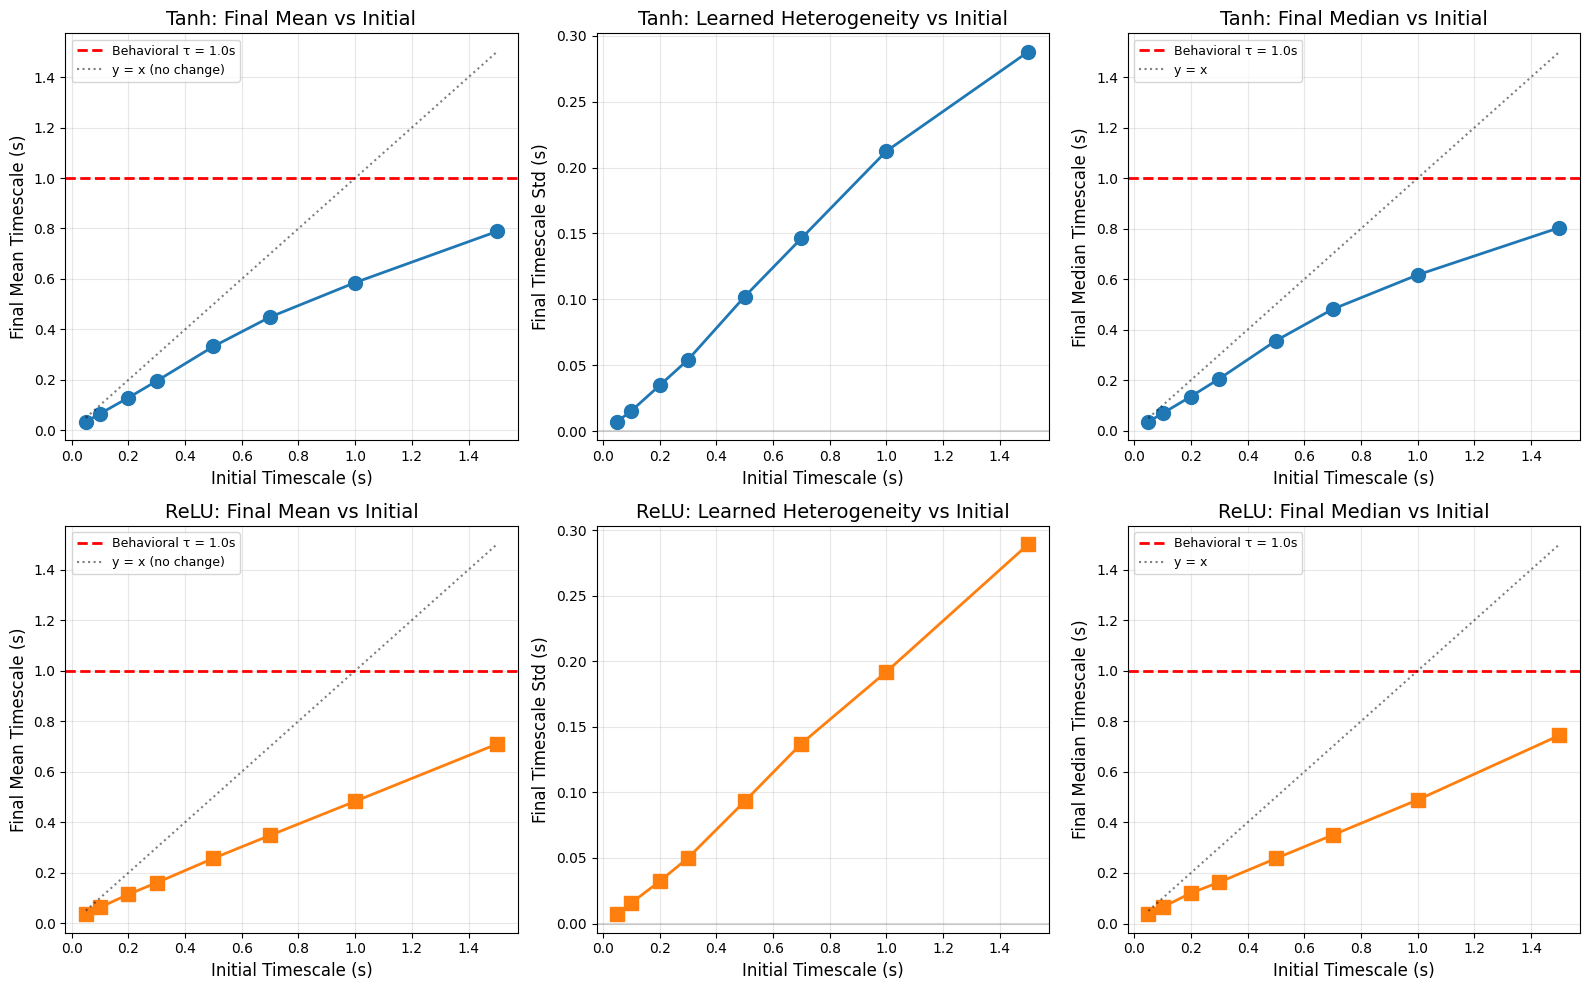


SUMMARY: Does the learned distribution depend on initialization?

Behavioral timescale: 1.0s

Tanh Networks:
  Final mean timescales across all inits: 0.323 ± 0.251s
  Final std (heterogeneity) across all inits: 0.108 ± 0.095s

ReLU Networks:
  Final mean timescales across all inits: 0.271 ± 0.218s
  Final std (heterogeneity) across all inits: 0.102 ± 0.093s

If std of means is low → similar final distributions regardless of init


In [7]:
# Summary statistics plot - grouped by activation type
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Colors and markers for activation types
act_styles = {
    "Tanh": {"color": "tab:blue", "marker": "o"},
    "ReLU": {"color": "tab:orange", "marker": "s"},
}

for row_idx, activation in enumerate(activation_types):
    act_results = results[activation]
    init_taus = sorted(act_results.keys())
    means = [act_results[t]["timescales"].mean() for t in init_taus]
    stds = [act_results[t]["timescales"].std() for t in init_taus]
    medians = [np.median(act_results[t]["timescales"]) for t in init_taus]

    style = act_styles[activation]

    # Plot 1: Final mean vs initial
    ax = axes[row_idx, 0]
    ax.plot(
        init_taus,
        means,
        f"{style['marker']}-",
        markersize=10,
        linewidth=2,
        color=style["color"],
    )
    ax.axhline(
        behavioral_timescale_mean,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Behavioral τ = {behavioral_timescale_mean}s",
    )
    ax.plot(init_taus, init_taus, "k:", alpha=0.5, label="y = x (no change)")
    ax.set_xlabel("Initial Timescale (s)", fontsize=12)
    ax.set_ylabel("Final Mean Timescale (s)", fontsize=12)
    ax.set_title(f"{activation}: Final Mean vs Initial", fontsize=14)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

    # Plot 2: Final std vs initial
    ax = axes[row_idx, 1]
    ax.plot(
        init_taus,
        stds,
        f"{style['marker']}-",
        markersize=10,
        linewidth=2,
        color=style["color"],
    )
    ax.axhline(0, color="gray", linestyle="-", alpha=0.3)
    ax.set_xlabel("Initial Timescale (s)", fontsize=12)
    ax.set_ylabel("Final Timescale Std (s)", fontsize=12)
    ax.set_title(f"{activation}: Learned Heterogeneity vs Initial", fontsize=14)
    ax.grid(True, alpha=0.3)

    # Plot 3: Final median vs initial
    ax = axes[row_idx, 2]
    ax.plot(
        init_taus,
        medians,
        f"{style['marker']}-",
        markersize=10,
        linewidth=2,
        color=style["color"],
    )
    ax.axhline(
        behavioral_timescale_mean,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Behavioral τ = {behavioral_timescale_mean}s",
    )
    ax.plot(init_taus, init_taus, "k:", alpha=0.5, label="y = x")
    ax.set_xlabel("Initial Timescale (s)", fontsize=12)
    ax.set_ylabel("Final Median Timescale (s)", fontsize=12)
    ax.set_title(f"{activation}: Final Median vs Initial", fontsize=14)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary for each activation type
print("\n" + "=" * 70)
print("SUMMARY: Does the learned distribution depend on initialization?")
print("=" * 70)
print(f"\nBehavioral timescale: {behavioral_timescale_mean}s")

for activation in activation_types:
    act_results = results[activation]
    init_taus = sorted(act_results.keys())
    means = [act_results[t]["timescales"].mean() for t in init_taus]
    stds = [act_results[t]["timescales"].std() for t in init_taus]

    print(f"\n{activation} Networks:")
    print(
        f"  Final mean timescales across all inits: {np.mean(means):.3f} ± {np.std(means):.3f}s"
    )
    print(
        f"  Final std (heterogeneity) across all inits: {np.mean(stds):.3f} ± {np.std(stds):.3f}s"
    )

print(f"\nIf std of means is low → similar final distributions regardless of init")

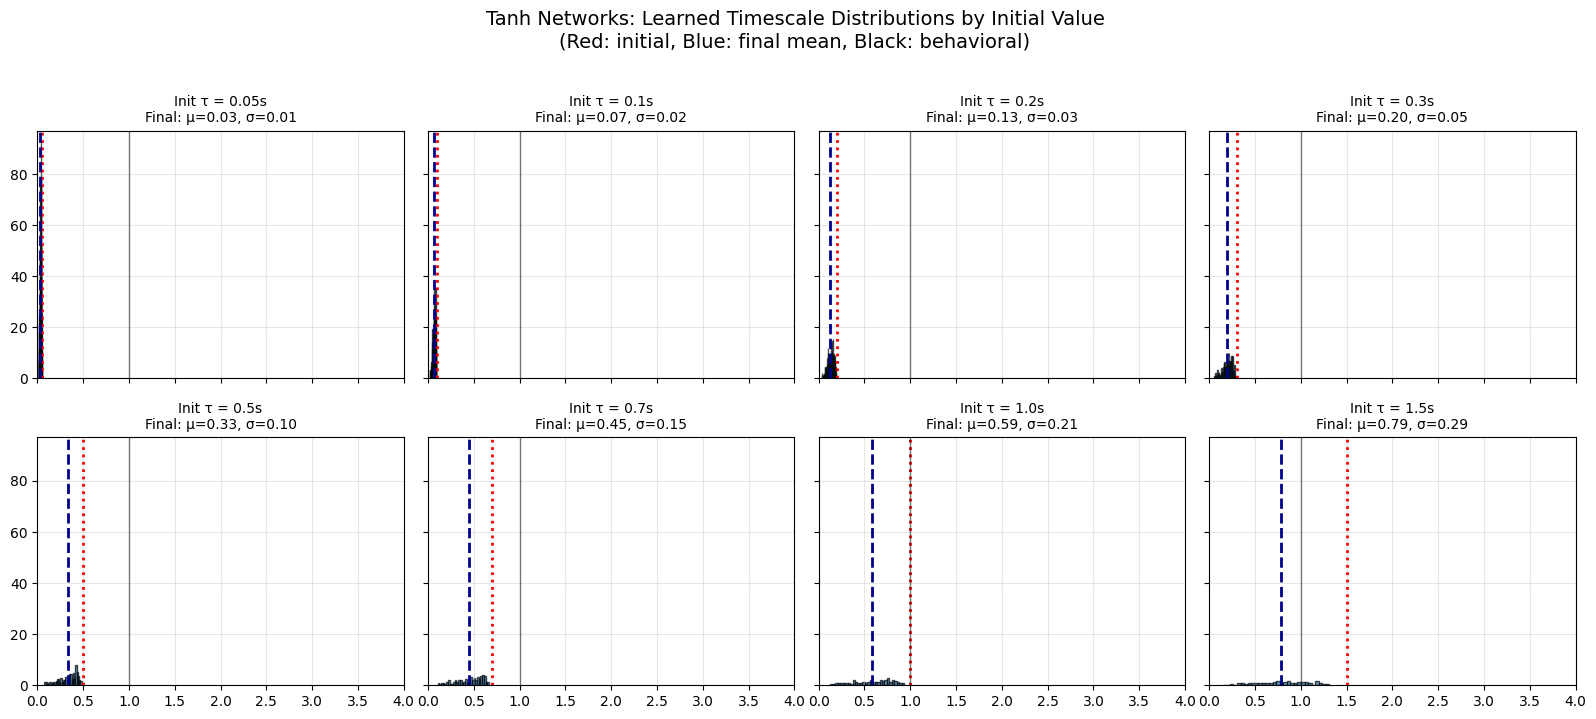

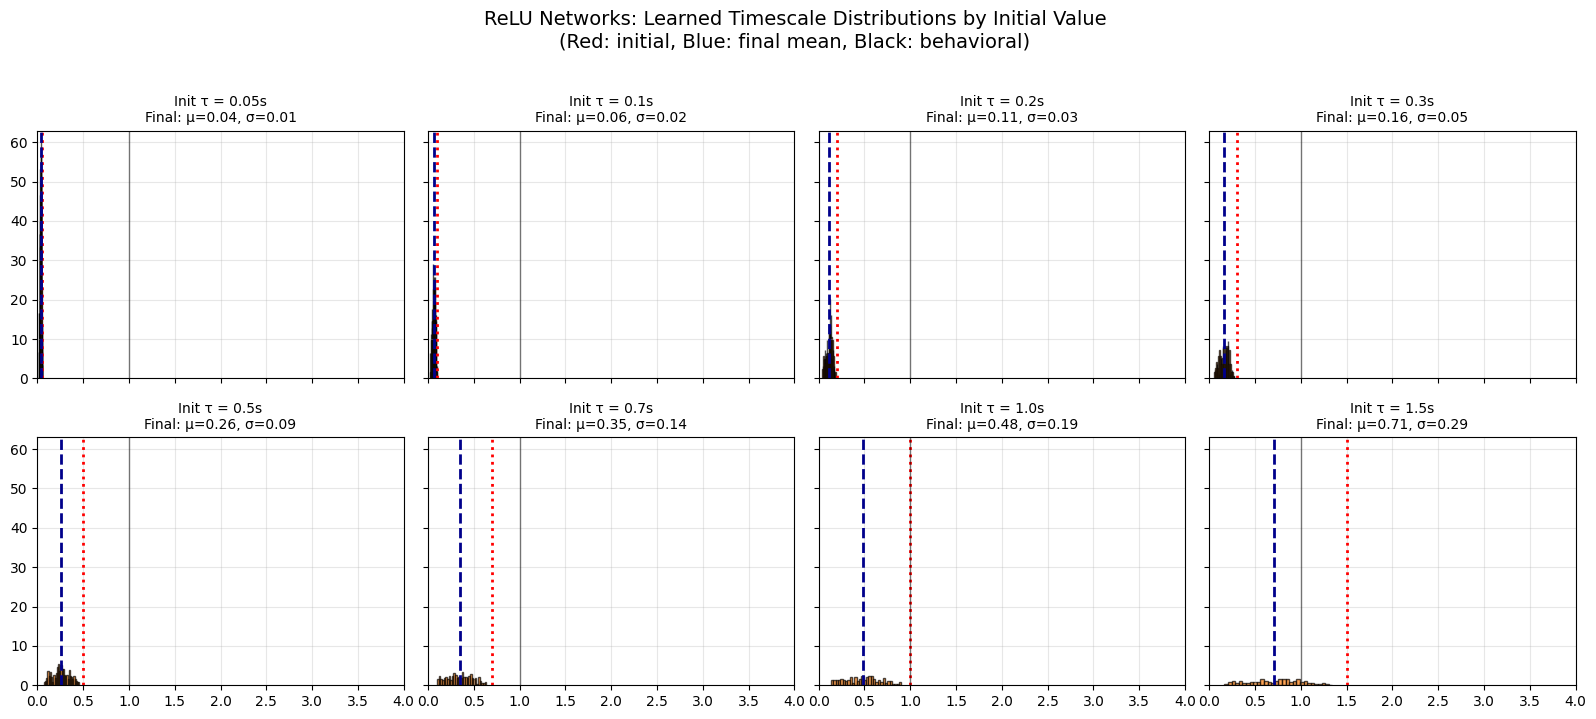

In [8]:
# Grid of individual histograms - grouped by activation type
# Create a figure for each activation type

for activation in activation_types:
    act_results = results[activation]
    n_exps = len(act_results)
    n_cols = 4
    n_rows = (n_exps + n_cols - 1) // n_cols

    # Different colors for each activation
    hist_color = "tab:blue" if activation == "Tanh" else "tab:orange"

    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(16, 3.5 * n_rows), sharex=True, sharey=True
    )
    axes = axes.flatten()

    for i, (init_tau, data) in enumerate(sorted(act_results.items())):
        ax = axes[i]

        # Plot learned distribution
        ax.hist(
            data["timescales"],
            bins=30,
            alpha=0.7,
            color=hist_color,
            edgecolor="black",
            density=True,
        )

        # Reference lines
        ax.axvline(init_tau, color="red", linestyle=":", linewidth=2, label="Initial")
        ax.axvline(
            data["timescales"].mean(),
            color="darkblue",
            linestyle="--",
            linewidth=2,
            label="Final mean",
        )
        ax.axvline(
            behavioral_timescale_mean,
            color="black",
            linestyle="-",
            linewidth=1,
            alpha=0.5,
        )

        ax.set_title(
            f'Init τ = {init_tau}s\nFinal: μ={data["timescales"].mean():.2f}, σ={data["timescales"].std():.2f}',
            fontsize=10,
        )
        ax.set_xlim(0, 4)
        ax.grid(True, alpha=0.3)

    # Hide empty subplots
    for i in range(len(act_results), len(axes)):
        axes[i].set_visible(False)

    fig.suptitle(
        f"{activation} Networks: Learned Timescale Distributions by Initial Value\n"
        "(Red: initial, Blue: final mean, Black: behavioral)",
        fontsize=14,
        y=1.02,
    )
    plt.tight_layout()
    plt.show()

## Decoding Error vs Epochs (All Models)

In [ ]:
# Load decoding errors for each experiment - grouped by activation type
decoding_data = {act: {} for act in activation_types}

for activation in activation_types:
    print(f"\n=== {activation} Networks ===")
    for init_tau in init_timescales:
        exp_name = f"init_tau_{format_value(init_tau)}_{activation}"
        exp_path = sweep_dir / exp_name / "seed_0"
    
        try:
            with open(exp_path / "position_decoding_errors.json") as f:
                errors = json.load(f)
            decoding_data[activation][init_tau] = {
                "epochs": np.array(errors["epochs"]),
                "decoding_error": np.array(errors["position_errors_epoch"]),
            }
            print(
                f"  Loaded init_tau={init_tau}: final={decoding_data[activation][init_tau]['decoding_error'][-1]:.4f}m"
            )
        except Exception as e:
            print(f"  Failed to load init_tau={init_tau}: {e}")

total_loaded = sum(len(d) for d in decoding_data.values())
print(f"\nLoaded decoding errors for {total_loaded} experiments")

Loaded decoding errors for init_tau=0.1: final=0.0424m
Loaded decoding errors for init_tau=0.2: final=0.0420m
Loaded decoding errors for init_tau=0.3: final=0.0428m
Loaded decoding errors for init_tau=0.5: final=0.0438m
Loaded decoding errors for init_tau=0.7: final=0.0457m
Loaded decoding errors for init_tau=1.0: final=0.0486m
Loaded decoding errors for init_tau=1.5: final=0.0525m

Loaded decoding errors for 7 experiments


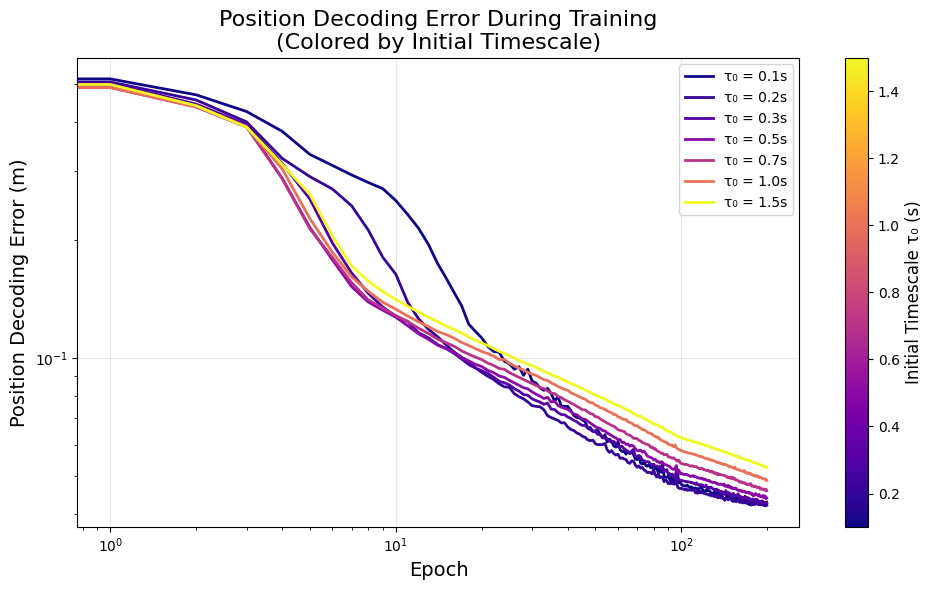

In [ ]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

# Create figure with subplots for each activation type
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax_idx, activation in enumerate(activation_types):
    ax = axes[ax_idx]
    act_decoding = decoding_data[activation]
    
    # Create colormap normalized to init_timescale range
    sorted_taus = sorted(act_decoding.keys())
    norm = Normalize(vmin=min(sorted_taus), vmax=max(sorted_taus))
    cmap = cm.plasma  # Nice smooth colormap
    
    # Plot each experiment's decoding error
    for init_tau in sorted_taus:
        data = act_decoding[init_tau]
        color = cmap(norm(init_tau))
        ax.plot(
            data["epochs"],
            data["decoding_error"],
            color=color,
            linewidth=2,
            label=f"τ₀ = {init_tau}s",
        )
    
    # Add colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("Initial Timescale τ₀ (s)", fontsize=12)
    
    ax.set_xlabel("Epoch", fontsize=14)
    ax.set_ylabel("Position Decoding Error (m)", fontsize=14)
    ax.set_title(f"{activation} Networks", fontsize=16)
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper right", fontsize=9)
    ax.set_yscale("log")
    ax.set_xscale("log")

plt.suptitle("Position Decoding Error During Training\n(Colored by Initial Timescale)", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

## OOD Generalization: Trajectory Length

Test how well each model generalizes to trajectory lengths longer than training.


In [ ]:
from timescales.datamodule import PathIntegrationDataModule
from timescales.analysis.measurements import PositionDecodingMeasurement

# Test trajectory lengths (training was 20 timesteps)
test_lengths = [20, 30, 50, 75, 100, 150, 200]
num_test_trajectories = 200


# Load models with place cell centers
def load_model_for_ood(sweep_dir, init_tau, activation, seed=0):
    """Load model and place cell centers for OOD testing."""
    exp_name = f"init_tau_{format_value(init_tau)}_{activation}"
    exp_path = sweep_dir / exp_name / f"seed_{seed}"

    # Load config
    with open(exp_path / f"config_seed{seed}.yaml") as f:
        config = yaml.safe_load(f)

    # Load place cell centers
    place_cell_centers = torch.load(exp_path / f"place_cell_centers_seed{seed}.pt")

    # Find best checkpoint
    checkpoint_dir = exp_path / "checkpoints"
    best_checkpoints = list(checkpoint_dir.glob("best-model-*.ckpt"))
    checkpoint_path = (
        best_checkpoints[0] if best_checkpoints else checkpoint_dir / "last.ckpt"
    )

    # Load checkpoint and create model
    checkpoint = torch.load(checkpoint_path, map_location="cpu")
    model = MultiTimescaleRNN(
        input_size=config["input_size"],
        hidden_size=config["hidden_size"],
        output_size=config["num_place_cells"],
        dt=config["dt"],
        timescales_config=None,
        activation=getattr(nn, config["activation"]),
        learn_timescales=True,
        init_timescale=init_tau,
    )
    lightning_module = MultiTimescaleRNNLightning(
        model=model,
        learning_rate=config["learning_rate"],
        weight_decay=config["weight_decay"],
        step_size=config["step_size"],
        gamma=config["gamma"],
    )
    lightning_module.load_state_dict(checkpoint["state_dict"])

    return model, config, place_cell_centers


# Load all models - grouped by activation type
models_for_ood = {act: {} for act in activation_types}

print("Loading models for OOD testing...")
for activation in activation_types:
    print(f"\n=== {activation} Networks ===")
    for init_tau in init_timescales:
        try:
            models_for_ood[activation][init_tau] = load_model_for_ood(sweep_dir, init_tau, activation)
            print(f"  ✓ Loaded init_tau={init_tau}")
        except Exception as e:
            print(f"  ✗ Failed init_tau={init_tau}: {e}")

Loading models for OOD testing...
Timescales are LEARNABLE (uniform init at τ=0.1s)
  ✓ Loaded init_tau=0.1
Timescales are LEARNABLE (uniform init at τ=0.2s)
  ✓ Loaded init_tau=0.2
Timescales are LEARNABLE (uniform init at τ=0.3s)
  ✓ Loaded init_tau=0.3
Timescales are LEARNABLE (uniform init at τ=0.5s)
  ✓ Loaded init_tau=0.5
Timescales are LEARNABLE (uniform init at τ=0.7s)
  ✓ Loaded init_tau=0.7
Timescales are LEARNABLE (uniform init at τ=1.0s)
  ✓ Loaded init_tau=1.0
Timescales are LEARNABLE (uniform init at τ=1.5s)
  ✓ Loaded init_tau=1.5


In [ ]:
def evaluate_ood(model, config, place_cell_centers, test_lengths, num_trajectories=200):
    """Evaluate model on different trajectory lengths."""
    model.eval()
    measurement = PositionDecodingMeasurement(decode_k=3)
    errors = []

    for test_length in test_lengths:
        # Create datamodule with different trajectory length
        datamodule = PathIntegrationDataModule(
            trajectory_type=config["trajectory_type"],
            velocity_representation=config["velocity_representation"],
            dt=config["dt"],
            num_time_steps=test_length,  # Vary this for OOD test
            arena_size=config["arena_size"],
            num_place_cells=config["num_place_cells"],
            place_cell_rf=config["place_cell_rf"],
            DoG=config["DoG"],
            surround_scale=config["surround_scale"],
            place_cell_layout=config["place_cell_layout"],
            # Speed params - use behavioral timescale if available
            behavioral_timescale_mean=config.get("behavioral_timescale_mean"),
            behavioral_timescale_std=config.get("behavioral_timescale_std"),
            linear_speed_mean=config.get("linear_speed_mean"),
            linear_speed_std=config.get("linear_speed_std"),
            linear_speed_tau=config.get("linear_speed_tau", 1.0),
            angular_speed_mean=config.get("angular_speed_mean", 0.0),
            angular_speed_std=config.get("angular_speed_std", 1.0),
            angular_speed_tau=config.get("angular_speed_tau", 0.4),
            # DataLoader params
            num_trajectories=num_trajectories,
            batch_size=min(config["batch_size"], num_trajectories),
            num_workers=10,
            train_val_split=0.0,  # All data goes to validation
        )
        datamodule.place_cell_centers = place_cell_centers
        datamodule.setup()

        # Measure decoding error
        error = measurement.compute(model, datamodule)
        errors.append(error)

    return errors


# Run OOD evaluation for all models - grouped by activation type
print(
    f"\nEvaluating OOD generalization across {len(test_lengths)} trajectory lengths..."
)
print(f"Test lengths: {test_lengths}")

ood_results = {act: {} for act in activation_types}

for activation in activation_types:
    print(f"\n{'='*60}")
    print(f"=== {activation} Networks ===")
    print('='*60)
    
    for init_tau in sorted(models_for_ood[activation].keys()):
        model, config, place_cell_centers = models_for_ood[activation][init_tau]
        print(f"Evaluating init_tau={init_tau}...", end=" ", flush=True)
        errors = evaluate_ood(
            model, config, place_cell_centers, test_lengths, num_test_trajectories
        )
        ood_results[activation][init_tau] = errors
        print(f"Done. Train error={errors[0]:.4f}m, Max OOD error={max(errors):.4f}m")

print("\n✓ OOD evaluation complete")


Evaluating OOD generalization across 7 trajectory lengths...
Test lengths: [20, 30, 50, 75, 100, 150, 200]
------------------------------------------------------------
Evaluating init_tau=0.1... Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.200s
  → linear_speed: mean=0.200m/s, std=0.040m/s
Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.200s
  → linear_speed: mean=0.200m/s, std=0.040m/s
Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.200s
  → linear_speed: mean=0.200m/s, std=0.040m/s
Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.200s
  → linear_speed: mean=0.200m/s, std=0.040m/s
Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.200s
  → linear_speed: mean=0.200m/s, std=0.040m/s
Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.200s
  → linear_speed: mean=0.200m/s, std=0.040m/s
Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, 

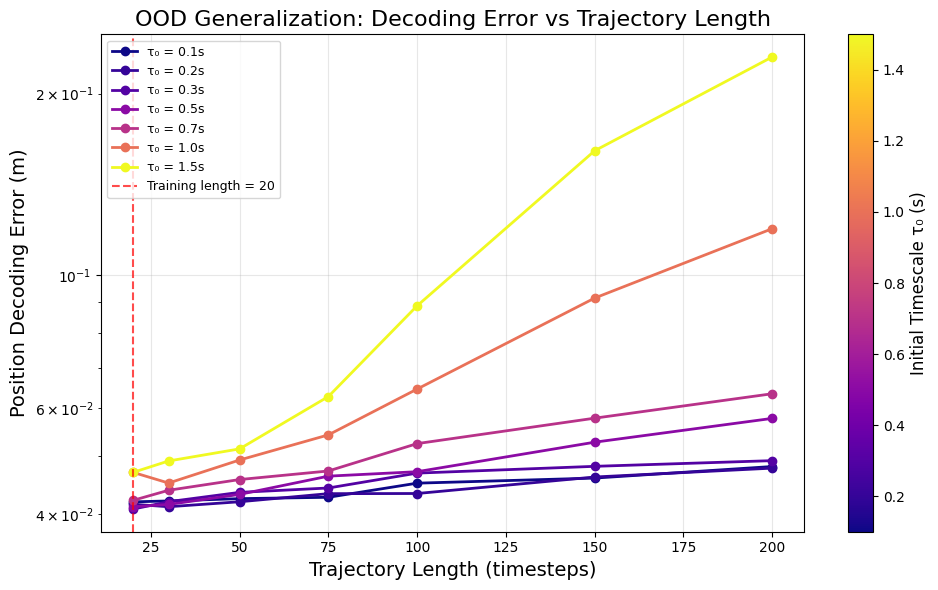

In [ ]:
# Plot OOD error vs trajectory length for each init_tau - grouped by activation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax_idx, activation in enumerate(activation_types):
    ax = axes[ax_idx]
    act_ood = ood_results[activation]
    
    sorted_taus = sorted(act_ood.keys())
    norm = Normalize(vmin=min(sorted_taus), vmax=max(sorted_taus))
    cmap = cm.plasma
    
    for init_tau in sorted_taus:
        errors = act_ood[init_tau]
        color = cmap(norm(init_tau))
        ax.plot(
            test_lengths,
            errors,
            "o-",
            color=color,
            linewidth=2,
            markersize=6,
            label=f"τ₀ = {init_tau}s",
        )
    
    # Mark training length
    training_length = 20
    ax.axvline(
        training_length,
        color="red",
        linestyle="--",
        linewidth=1.5,
        alpha=0.7,
        label=f"Training length = {training_length}",
    )
    
    # Colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("Initial Timescale τ₀ (s)", fontsize=12)
    
    ax.set_xlabel("Trajectory Length (timesteps)", fontsize=14)
    ax.set_ylabel("Position Decoding Error (m)", fontsize=14)
    ax.set_title(f"{activation} Networks", fontsize=16)
    ax.legend(loc="upper left", fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_yscale("log")

plt.suptitle("OOD Generalization: Decoding Error vs Trajectory Length", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

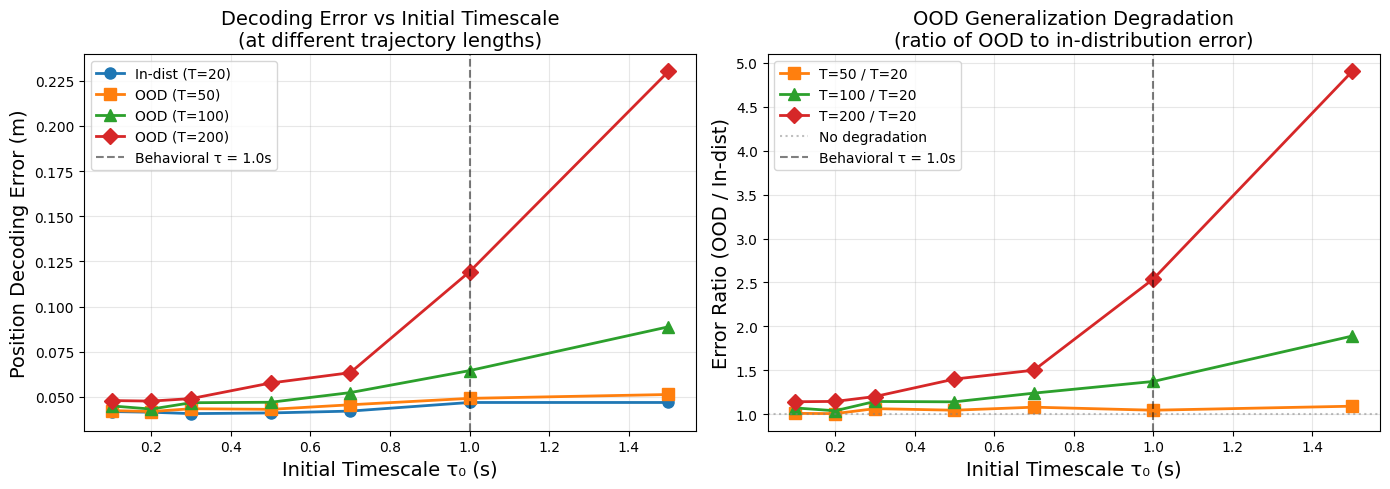


OOD GENERALIZATION SUMMARY

Training trajectory length: 20 timesteps
Longest test trajectory: 200 timesteps (10x longer)

Error at longest trajectory by initial timescale:
  τ₀ =  0.1s  →  0.0480m  (1.1x degradation)
  τ₀ =  0.2s  →  0.0477m  (1.1x degradation)
  τ₀ =  0.3s  →  0.0491m  (1.2x degradation)
  τ₀ =  0.5s  →  0.0577m  (1.4x degradation)
  τ₀ =  0.7s  →  0.0634m  (1.5x degradation)
  τ₀ =  1.0s  →  0.1193m  (2.5x degradation)
  τ₀ =  1.5s  →  0.2301m  (4.9x degradation)


In [ ]:
# Plot OOD generalization error vs initial timescale - grouped by activation
# Use error at longest trajectory length as the "OOD error"

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for row_idx, activation in enumerate(activation_types):
    act_ood = ood_results[activation]
    sorted_taus = sorted(act_ood.keys())
    
    # Get errors at specific OOD lengths
    ood_errors_50 = [act_ood[tau][test_lengths.index(50)] for tau in sorted_taus]
    ood_errors_100 = [act_ood[tau][test_lengths.index(100)] for tau in sorted_taus]
    ood_errors_200 = [act_ood[tau][test_lengths.index(200)] for tau in sorted_taus]
    in_dist_errors = [act_ood[tau][0] for tau in sorted_taus]  # At training length
    
    # Left plot: Error at different trajectory lengths vs init tau
    ax = axes[row_idx, 0]
    ax.plot(
        sorted_taus,
        in_dist_errors,
        "o-",
        linewidth=2,
        markersize=8,
        label=f"In-dist (T={test_lengths[0]})",
        color="tab:blue",
    )
    ax.plot(
        sorted_taus,
        ood_errors_50,
        "s-",
        linewidth=2,
        markersize=8,
        label=f"OOD (T=50)",
        color="tab:orange",
    )
    ax.plot(
        sorted_taus,
        ood_errors_100,
        "^-",
        linewidth=2,
        markersize=8,
        label=f"OOD (T=100)",
        color="tab:green",
    )
    ax.plot(
        sorted_taus,
        ood_errors_200,
        "D-",
        linewidth=2,
        markersize=8,
        label=f"OOD (T=200)",
        color="tab:red",
    )
    
    ax.axvline(
        behavioral_timescale_mean,
        color="black",
        linestyle="--",
        alpha=0.5,
        label=f"Behavioral τ = {behavioral_timescale_mean}s",
    )
    
    ax.set_xlabel("Initial Timescale τ₀ (s)", fontsize=12)
    ax.set_ylabel("Position Decoding Error (m)", fontsize=12)
    ax.set_title(f"{activation}: Decoding Error vs Initial Timescale", fontsize=14)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Right plot: OOD degradation (ratio of OOD to in-dist error)
    ax = axes[row_idx, 1]
    degradation_50 = [ood_errors_50[i] / in_dist_errors[i] for i in range(len(sorted_taus))]
    degradation_100 = [ood_errors_100[i] / in_dist_errors[i] for i in range(len(sorted_taus))]
    degradation_200 = [ood_errors_200[i] / in_dist_errors[i] for i in range(len(sorted_taus))]
    
    ax.plot(
        sorted_taus,
        degradation_50,
        "s-",
        linewidth=2,
        markersize=8,
        label="T=50 / T=20",
        color="tab:orange",
    )
    ax.plot(
        sorted_taus,
        degradation_100,
        "^-",
        linewidth=2,
        markersize=8,
        label="T=100 / T=20",
        color="tab:green",
    )
    ax.plot(
        sorted_taus,
        degradation_200,
        "D-",
        linewidth=2,
        markersize=8,
        label="T=200 / T=20",
        color="tab:red",
    )
    
    ax.axhline(1.0, color="gray", linestyle=":", alpha=0.5, label="No degradation")
    ax.axvline(
        behavioral_timescale_mean,
        color="black",
        linestyle="--",
        alpha=0.5,
        label=f"Behavioral τ = {behavioral_timescale_mean}s",
    )
    
    ax.set_xlabel("Initial Timescale τ₀ (s)", fontsize=12)
    ax.set_ylabel("Error Ratio (OOD / In-dist)", fontsize=12)
    ax.set_title(f"{activation}: OOD Generalization Degradation", fontsize=14)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary
print("\n" + "=" * 70)
print("OOD GENERALIZATION SUMMARY")
print("=" * 70)
print(f"\nTraining trajectory length: {test_lengths[0]} timesteps")
print(f"Longest test trajectory: {test_lengths[-1]} timesteps ({test_lengths[-1]/test_lengths[0]:.0f}x longer)")

for activation in activation_types:
    act_ood = ood_results[activation]
    sorted_taus = sorted(act_ood.keys())
    ood_errors_200 = [act_ood[tau][test_lengths.index(200)] for tau in sorted_taus]
    
    print(f"\n{activation} Networks - Error at longest trajectory by initial timescale:")
    for tau, err in zip(sorted_taus, ood_errors_200):
        degradation = err / act_ood[tau][0]
        print(f"  τ₀ = {tau:>4}s  →  {err:.4f}m  ({degradation:.1f}x degradation)")

## OOD Generalization: Behavioral Timescale Mean

Test how well each model generalizes when we change the behavioral timescale mean (i.e., speed of the agent).


In [ ]:
# Test behavioral timescale means (training was at mean=1.0s)
test_behav_means = [0.2, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 3.0]
training_behav_mean = behavioral_timescale_mean  # From config (1.0s)
training_behav_std = behavioral_timescale_std  # From config (0.2s)


def evaluate_ood_behav_mean(
    model, config, place_cell_centers, test_means, behav_std=0.2, num_trajectories=200
):
    """Evaluate model with different behavioral timescale means."""
    model.eval()
    measurement = PositionDecodingMeasurement(decode_k=3)
    errors = []

    for behav_mean in test_means:
        datamodule = PathIntegrationDataModule(
            trajectory_type=config["trajectory_type"],
            velocity_representation=config["velocity_representation"],
            dt=config["dt"],
            num_time_steps=config["num_time_steps"],
            arena_size=config["arena_size"],
            num_place_cells=config["num_place_cells"],
            place_cell_rf=config["place_cell_rf"],
            DoG=config["DoG"],
            surround_scale=config["surround_scale"],
            place_cell_layout=config["place_cell_layout"],
            # Vary behavioral timescale mean
            behavioral_timescale_mean=behav_mean,
            behavioral_timescale_std=behav_std,
            linear_speed_tau=config.get("linear_speed_tau", 1.0),
            angular_speed_mean=config.get("angular_speed_mean", 0.0),
            angular_speed_std=config.get("angular_speed_std", 1.0),
            angular_speed_tau=config.get("angular_speed_tau", 0.4),
            num_trajectories=num_trajectories,
            batch_size=min(config["batch_size"], num_trajectories),
            num_workers=10,
            train_val_split=0.0,
        )
        datamodule.place_cell_centers = place_cell_centers
        datamodule.setup()

        error = measurement.compute(model, datamodule)
        errors.append(error)

    return errors


# Evaluate OOD for behavioral timescale mean - grouped by activation
print(f"\nEvaluating OOD generalization across {len(test_behav_means)} behavioral timescale means...")
print(f"Test means: {test_behav_means}")
print(f"Training mean: {training_behav_mean}s")

ood_behav_mean_results = {act: {} for act in activation_types}

for activation in activation_types:
    print(f"\n{'='*60}")
    print(f"=== {activation} Networks ===")
    print('='*60)
    
    for init_tau in sorted(models_for_ood[activation].keys()):
        model, config, place_cell_centers = models_for_ood[activation][init_tau]
        print(f"Evaluating init_tau={init_tau}...", end=" ", flush=True)
        errors = evaluate_ood_behav_mean(
            model,
            config,
            place_cell_centers,
            test_behav_means,
            behav_std=training_behav_std,
            num_trajectories=num_test_trajectories,
        )
        ood_behav_mean_results[activation][init_tau] = errors
        in_dist_idx = (
            test_behav_means.index(training_behav_mean)
            if training_behav_mean in test_behav_means
            else 0
        )
        print(f"Done. In-dist error={errors[in_dist_idx]:.4f}m")

print("\n✓ Behavioral timescale mean OOD evaluation complete")


Evaluating OOD generalization across 8 behavioral timescale means...
Test means: [0.2, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 3.0]
Training mean: 1.0s
------------------------------------------------------------
Evaluating init_tau=0.1... 

Behavioral timescale parameterization:
  τ_behavior: mean=0.200s, std=0.200s
  → linear_speed: mean=1.000m/s, std=1.000m/s
Behavioral timescale parameterization:
  τ_behavior: mean=0.300s, std=0.200s
  → linear_speed: mean=0.667m/s, std=0.444m/s
Behavioral timescale parameterization:
  τ_behavior: mean=0.500s, std=0.200s
  → linear_speed: mean=0.400m/s, std=0.160m/s
Behavioral timescale parameterization:
  τ_behavior: mean=0.700s, std=0.200s
  → linear_speed: mean=0.286m/s, std=0.082m/s
Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.200s
  → linear_speed: mean=0.200m/s, std=0.040m/s
Behavioral timescale parameterization:
  τ_behavior: mean=1.500s, std=0.200s
  → linear_speed: mean=0.133m/s, std=0.018m/s
Behavioral timescale parameterization:
  τ_behavior: mean=2.000s, std=0.200s
  → linear_speed: mean=0.100m/s, std=0.010m/s
Behavioral timescale parameterization:
  τ_behavior: mean=3.000s, std=0.200s
  → linear_speed: mean=0.067m/s, std=0.004m/s
Done. In-dist er

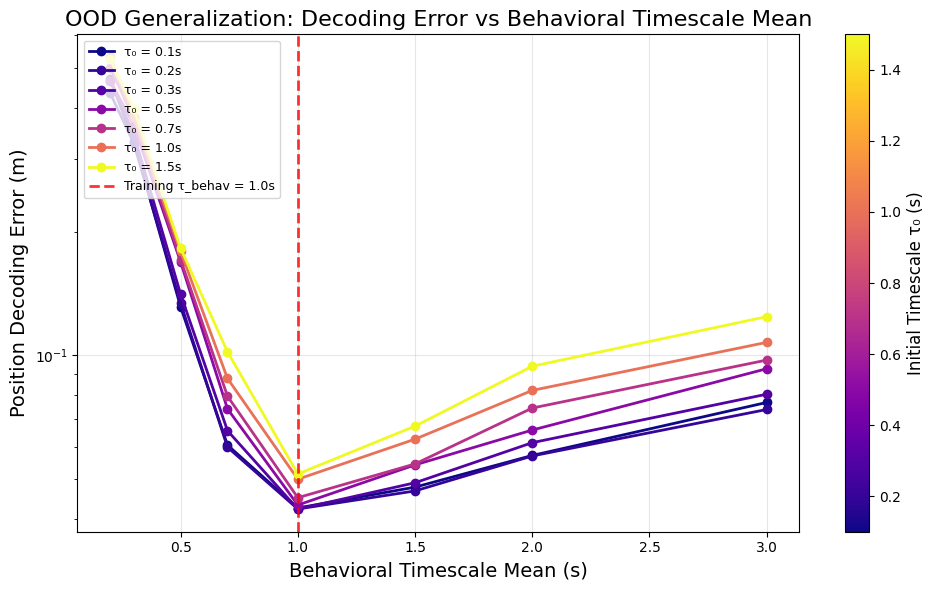


Decoding Error by Behavioral Timescale Mean:
------------------------------------------------------------
  τ₀ =  0.1s  →  In-dist: 0.0426m, Range: [0.0426, 0.4690]m
  τ₀ =  0.2s  →  In-dist: 0.0423m, Range: [0.0423, 0.4334]m
  τ₀ =  0.3s  →  In-dist: 0.0423m, Range: [0.0423, 0.4643]m
  τ₀ =  0.5s  →  In-dist: 0.0433m, Range: [0.0433, 0.4656]m
  τ₀ =  0.7s  →  In-dist: 0.0451m, Range: [0.0451, 0.4997]m
  τ₀ =  1.0s  →  In-dist: 0.0500m, Range: [0.0500, 0.5312]m
  τ₀ =  1.5s  →  In-dist: 0.0515m, Range: [0.0515, 0.5238]m


In [ ]:
# Plot OOD error vs behavioral timescale mean - grouped by activation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax_idx, activation in enumerate(activation_types):
    ax = axes[ax_idx]
    act_ood = ood_behav_mean_results[activation]
    
    sorted_taus = sorted(act_ood.keys())
    norm = Normalize(vmin=min(sorted_taus), vmax=max(sorted_taus))
    cmap = cm.plasma
    
    for init_tau in sorted_taus:
        errors = act_ood[init_tau]
        color = cmap(norm(init_tau))
        ax.plot(
            test_behav_means,
            errors,
            "o-",
            color=color,
            linewidth=2,
            markersize=6,
            label=f"τ₀ = {init_tau}s",
        )
    
    # Mark training behavioral timescale mean
    ax.axvline(
        training_behav_mean,
        color="red",
        linestyle="--",
        linewidth=2,
        alpha=0.8,
        label=f"Training τ_behav = {training_behav_mean}s",
    )
    
    # Colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("Initial Timescale τ₀ (s)", fontsize=12)
    
    ax.set_xlabel("Behavioral Timescale Mean (s)", fontsize=14)
    ax.set_ylabel("Position Decoding Error (m)", fontsize=14)
    ax.set_title(f"{activation} Networks", fontsize=16)
    ax.legend(loc="upper left", fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_yscale("log")

plt.suptitle("OOD Generalization: Decoding Error vs Behavioral Timescale Mean", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

# Print summary
print("\nDecoding Error by Behavioral Timescale Mean:")
print("-" * 60)
in_dist_idx = (
    test_behav_means.index(training_behav_mean)
    if training_behav_mean in test_behav_means
    else 0
)
for activation in activation_types:
    print(f"\n{activation} Networks:")
    act_ood = ood_behav_mean_results[activation]
    sorted_taus = sorted(act_ood.keys())
    for init_tau in sorted_taus:
        errors = act_ood[init_tau]
        in_dist_err = errors[in_dist_idx]
        min_err, max_err = min(errors), max(errors)
        print(f"  τ₀ = {init_tau:>4}s  →  In-dist: {in_dist_err:.4f}m, Range: [{min_err:.4f}, {max_err:.4f}]m")

## OOD Generalization: Behavioral Timescale Std

Test how well each model generalizes when we change the behavioral timescale std (i.e., variability in speed).


In [ ]:
# Test behavioral timescale stds (training was at std=0.2s)
test_behav_stds = [0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0]


def evaluate_ood_behav_std(
    model, config, place_cell_centers, test_stds, behav_mean=1.0, num_trajectories=200
):
    """Evaluate model with different behavioral timescale stds."""
    model.eval()
    measurement = PositionDecodingMeasurement(decode_k=3)
    errors = []

    for behav_std in test_stds:
        datamodule = PathIntegrationDataModule(
            trajectory_type=config["trajectory_type"],
            velocity_representation=config["velocity_representation"],
            dt=config["dt"],
            num_time_steps=config["num_time_steps"],
            arena_size=config["arena_size"],
            num_place_cells=config["num_place_cells"],
            place_cell_rf=config["place_cell_rf"],
            DoG=config["DoG"],
            surround_scale=config["surround_scale"],
            place_cell_layout=config["place_cell_layout"],
            # Vary behavioral timescale std
            behavioral_timescale_mean=behav_mean,
            behavioral_timescale_std=behav_std,
            linear_speed_tau=config.get("linear_speed_tau", 1.0),
            angular_speed_mean=config.get("angular_speed_mean", 0.0),
            angular_speed_std=config.get("angular_speed_std", 1.0),
            angular_speed_tau=config.get("angular_speed_tau", 0.4),
            num_trajectories=num_trajectories,
            batch_size=min(config["batch_size"], num_trajectories),
            num_workers=10,
            train_val_split=0.0,
        )
        datamodule.place_cell_centers = place_cell_centers
        datamodule.setup()

        error = measurement.compute(model, datamodule)
        errors.append(error)

    return errors


# Evaluate OOD for behavioral timescale std - grouped by activation
print(f"\nEvaluating OOD generalization across {len(test_behav_stds)} behavioral timescale stds...")
print(f"Test stds: {test_behav_stds}")
print(f"Training std: {training_behav_std}s")

ood_behav_std_results = {act: {} for act in activation_types}

for activation in activation_types:
    print(f"\n{'='*60}")
    print(f"=== {activation} Networks ===")
    print('='*60)
    
    for init_tau in sorted(models_for_ood[activation].keys()):
        model, config, place_cell_centers = models_for_ood[activation][init_tau]
        print(f"Evaluating init_tau={init_tau}...", end=" ", flush=True)
        errors = evaluate_ood_behav_std(
            model,
            config,
            place_cell_centers,
            test_behav_stds,
            behav_mean=training_behav_mean,
            num_trajectories=num_test_trajectories,
        )
        ood_behav_std_results[activation][init_tau] = errors
        in_dist_idx = (
            test_behav_stds.index(training_behav_std)
            if training_behav_std in test_behav_stds
            else 0
        )
        print(f"Done. In-dist error={errors[in_dist_idx]:.4f}m")

print("\n✓ Behavioral timescale std OOD evaluation complete")


Evaluating OOD generalization across 7 behavioral timescale stds...
Test stds: [0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0]
Training std: 0.2s
------------------------------------------------------------
Evaluating init_tau=0.1... 

Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.050s
  → linear_speed: mean=0.200m/s, std=0.010m/s
Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.100s
  → linear_speed: mean=0.200m/s, std=0.020m/s
Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.200s
  → linear_speed: mean=0.200m/s, std=0.040m/s
Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.300s
  → linear_speed: mean=0.200m/s, std=0.060m/s
Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.500s
  → linear_speed: mean=0.200m/s, std=0.100m/s
Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.700s
  → linear_speed: mean=0.200m/s, std=0.140m/s
Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=1.000s
  → linear_speed: mean=0.200m/s, std=0.200m/s
Done. In-dist error=0.0424m
Evaluating init_tau=0.2... Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.050s
  → lin

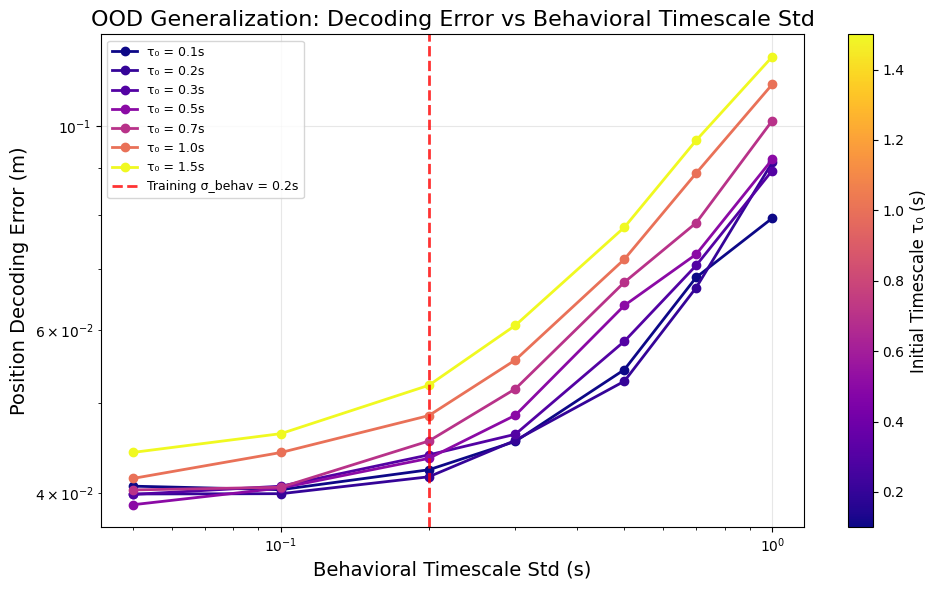


Decoding Error by Behavioral Timescale Std:
------------------------------------------------------------
  τ₀ =  0.1s  →  In-dist: 0.0424m, Range: [0.0403, 0.0794]m
  τ₀ =  0.2s  →  In-dist: 0.0416m, Range: [0.0399, 0.0913]m
  τ₀ =  0.3s  →  In-dist: 0.0440m, Range: [0.0398, 0.0895]m
  τ₀ =  0.5s  →  In-dist: 0.0436m, Range: [0.0388, 0.0920]m
  τ₀ =  0.7s  →  In-dist: 0.0455m, Range: [0.0403, 0.1014]m
  τ₀ =  1.0s  →  In-dist: 0.0485m, Range: [0.0415, 0.1110]m
  τ₀ =  1.5s  →  In-dist: 0.0523m, Range: [0.0442, 0.1189]m


In [ ]:
# Plot OOD error vs behavioral timescale std - grouped by activation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax_idx, activation in enumerate(activation_types):
    ax = axes[ax_idx]
    act_ood = ood_behav_std_results[activation]
    
    sorted_taus = sorted(act_ood.keys())
    norm = Normalize(vmin=min(sorted_taus), vmax=max(sorted_taus))
    cmap = cm.plasma
    
    for init_tau in sorted_taus:
        errors = act_ood[init_tau]
        color = cmap(norm(init_tau))
        ax.plot(
            test_behav_stds,
            errors,
            "o-",
            color=color,
            linewidth=2,
            markersize=6,
            label=f"τ₀ = {init_tau}s",
        )
    
    # Mark training behavioral timescale std
    ax.axvline(
        training_behav_std,
        color="red",
        linestyle="--",
        linewidth=2,
        alpha=0.8,
        label=f"Training σ_behav = {training_behav_std}s",
    )
    
    # Colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("Initial Timescale τ₀ (s)", fontsize=12)
    
    ax.set_xlabel("Behavioral Timescale Std (s)", fontsize=14)
    ax.set_ylabel("Position Decoding Error (m)", fontsize=14)
    ax.set_title(f"{activation} Networks", fontsize=16)
    ax.legend(loc="upper left", fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_xscale("log")
    ax.set_yscale("log")

plt.suptitle("OOD Generalization: Decoding Error vs Behavioral Timescale Std", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

# Print summary
print("\nDecoding Error by Behavioral Timescale Std:")
print("-" * 60)
in_dist_idx = (
    test_behav_stds.index(training_behav_std)
    if training_behav_std in test_behav_stds
    else 0
)
for activation in activation_types:
    print(f"\n{activation} Networks:")
    act_ood = ood_behav_std_results[activation]
    sorted_taus = sorted(act_ood.keys())
    for init_tau in sorted_taus:
        errors = act_ood[init_tau]
        in_dist_err = errors[in_dist_idx]
        min_err, max_err = min(errors), max(errors)
        print(f"  τ₀ = {init_tau:>4}s  →  In-dist: {in_dist_err:.4f}m, Range: [{min_err:.4f}, {max_err:.4f}]m")

In [40]:
# is diag(W_rec) = 0? Should it be?